In [118]:
import random
import tifffile
import numpy as np
import pandas as pd
from tqdm import tqdm
import io
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from datasets import Dataset
from PIL import Image
from IPython.display import display
from patchify import patchify

## Checkpoint

In [96]:
from datasets import load_dataset
train = load_dataset("back2classroom/sidewalks", split='train', streaming=True)
print(next(iter(train)))

{'filename': '1001_10_1', 'tfw': b'1.0000000000\r\n0.0000000000\r\n0.0000000000\r\n1.0000000000\r\n0.0000000000\r\n2304.0000000000\r\n', 'tif': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\

In [97]:
print(train)

IterableDataset({
    features: ['filename', 'tfw', 'tif', 'label_tif', 'label_tfw'],
    n_shards: 6
})


In [143]:
test_image_arr = []
test_label_arr = []
for idx, item in enumerate(train):
    test_image_arr.append(item['tif'])
    test_label_arr.append(item['label_tif'])
    if idx == 6:
        break

label_object = io.BytesIO(test_label_arr[5])
label_array = np.array(Image.open(label_object))

# Thresholding to convert to binary black and white
binary_lbl_arr = (label_array).astype(np.uint8)
print(binary_lbl_arr[0])

image_object = io.BytesIO(test_image_arr[5])
image_array = np.array(Image.open(image_object))

# Thresholding to convert to binary black and white
binary_img_arr = (image_array).astype(np.uint8)  /255
print(binary_img_arr[0])

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0.47843137 0.51764706 0.5254902 ]
 [0.75686275 0.85882353 0.85490196]
 [0.70980392 0.95294118 0.90980392]
 [0.60784314 0.96470588 0.89803922]
 [0.59607843 1.         0.94901961]
 [0.57647059 1.         0.94117647]
 [0.56862745 0.92156863 0.88235294]
 [0.51764706 0.72941176 0.7372549 ]
 [0.4745098  0.49803922 0.56078431]
 [0.20784314 0.09019608 0.19215686]
 [0.41568627 0.2        0.31372549]
 [0.42352941 0.21176471 0.30588235]
 [0.44313725 0.31764706 0.36078431]
 [0.47843137

In [164]:
image_arr = []
label_arr = []
tif_bytes = []
lbl_bytes = []
fname = []

def byte_string_to_binary(label, normalize=False):
    """
    Convert a byte string to a binary black and white numpy array.

    Args:
    - label: A byte string representing an image.
    - normalize: Boolean indicating whether to normalize the image array (default is False).

    Returns:
    - image_object: PIL Image object.
    - binary_img_arr: A binary black and white numpy array.
    """
    # Convert byte string to PIL Image object
    image_object = io.BytesIO(label)
    image_array = np.array(Image.open(image_object))

    # Thresholding to convert to binary black and white
    if normalize:
        binary_img_arr = (image_array).astype(np.uint8) / 255.0
    else:
        binary_img_arr = (image_array).astype(np.uint8)

    return image_object, binary_img_arr

TOTAL_ITER = 10000
progress_bar = tqdm(total=TOTAL_ITER, desc='Processing')

for idx, item in enumerate(train):
    image_object, image_array = byte_string_to_binary(item['tif'], normalize=False)
    label_object, label_array = byte_string_to_binary(item['label_tif'])
    # Check if the mask is not full black to filter out no-sidewalks img
    if not np.all(label_array[0] == 0):
        fname.append(item['filename'])
        tif_bytes.append(image_object)
        lbl_bytes.append(label_object)
        image_arr.append(image_array)
        label_arr.append(label_array)
    
    # Update the progress bar
    progress_bar.update(1)

    if idx == TOTAL_ITER:
        break

Processing: 10001it [24:06,  6.91it/s] 


In [165]:
# Create a DataFrame
df = pd.DataFrame({
    'image': tif_bytes,
    'label': lbl_bytes,
    'imgarr': image_arr,
    'lblarr': label_arr
})

# Export the DataFrame to a CSV file
df.to_pickle('dataset.pkl')

# Print the dimensions of the DataFrame
print("DataFrame Dimensions:", df.shape)

DataFrame Dimensions: (2820, 4)


## Train

In [72]:
data = pd.read_pickle('dataset.pkl')
print(data.head())

                                        image  \
0  <_io.BytesIO object at 0x00000184ADD9DE90>   
1  <_io.BytesIO object at 0x00000184ADD9DF80>   
2  <_io.BytesIO object at 0x00000184ADD9DEE0>   
3  <_io.BytesIO object at 0x00000184ADD9DFD0>   
4  <_io.BytesIO object at 0x00000184ADD9E020>   

                                        label  \
0  <_io.BytesIO object at 0x00000184ADD15210>   
1  <_io.BytesIO object at 0x00000184ADD153A0>   
2  <_io.BytesIO object at 0x00000184ADD15350>   
3  <_io.BytesIO object at 0x00000184ADD15170>   
4  <_io.BytesIO object at 0x00000184ADD15490>   

                                              imgarr  \
0  [[[122, 132, 134], [193, 219, 218], [181, 243,...   
1  [[[126, 64, 77], [124, 64, 72], [124, 68, 69],...   
2  [[[52, 36, 39], [59, 50, 51], [62, 68, 66], [5...   
3  [[[50, 102, 80], [104, 151, 131], [97, 131, 11...   
4  [[[108, 76, 89], [110, 78, 91], [112, 80, 93],...   

                                              lblarr  
0  [[1, 1, 1, 1, 1

In [76]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in data['imgarr']],
    "label": [Image.fromarray(mask) for mask in data['lblarr']],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2820
})

In [ ]:
# ex_image = dataset[0]["image"]
# print(ex_image)
# ex_array = np.array(ex_image)
# # Normalize the image array (assuming normalization means scaling pixel values between 0 and 1)
# ex_array_normalized = ex_array / 255.0
# # Convert the normalized numpy array back to PngImageFile
# normalized_image = Image.fromarray(ex_array_normalized)
# ex_image.convert('L')
# fig, axes = plt.subplots()
# axes.imshow(np.array(normalized_image))
# axes.title.set_text(f"Ground truth mask")
# axes.axis("off")

In [77]:
# # Accessing the image array at the specified index
# image_array = dataset[0]['image']
# print(image_array)
# img_gray = image_array.convert('L')
# print(img_gray)
# img_gray.show()

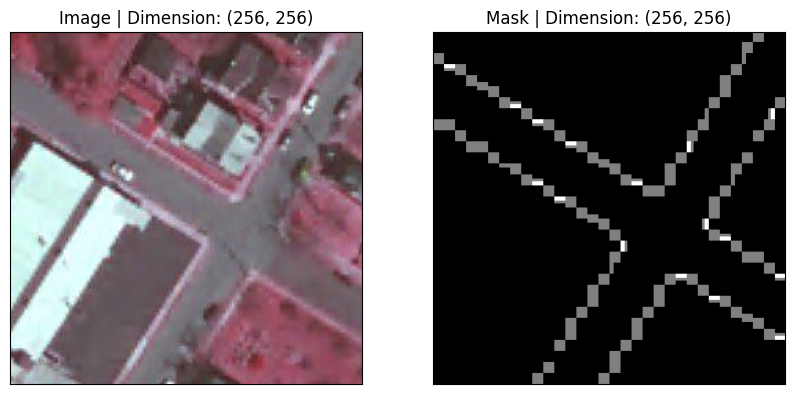

In [78]:
img_num = random.randint(0, dataset.shape[0])
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  
axes[0].set_title(f'Image | Dimension: {example_image.size}')

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title(f'Mask | Dimension: {example_image.size}')

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [79]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [80]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [35]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [36]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [85]:
# Load the model
import monai.losses
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

from torch.optim import Adam
import monai
from monai.metrics import DiceMetric

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
# seg_loss = monai.losses.DiceCELoss(sigmoid=True)
seg_loss = monai.losses.FocalLoss(use_softmax=False)

DiceCELoss: Compute both Dice loss and Cross Entropy Loss, and return the weighted sum of these two losses.

In [87]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
all_losses = []
num_epochs = 1
MAX_LOSS_THRES = -100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

      # Check if loss exceeds the threshold
      # if mean(epoch_losses) < MAX_LOSS_THRES:
      #     print(f"Loss exceeded maximum threshold ({MAX_LOSS_THRES}). Stopping training.")
      #     break
    
    all_losses.append(epoch_losses)
    
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 1410/1410 [55:28<00:00,  2.36s/it]

EPOCH: 0
Mean loss: 0.03609065897473801


In [93]:
LOSS_FILENAME = 'loss_history_focalloss.json'

In [94]:
# Save loss history to a local file
import json

with open(LOSS_FILENAME, 'w') as f:
    json.dump(all_losses, f)

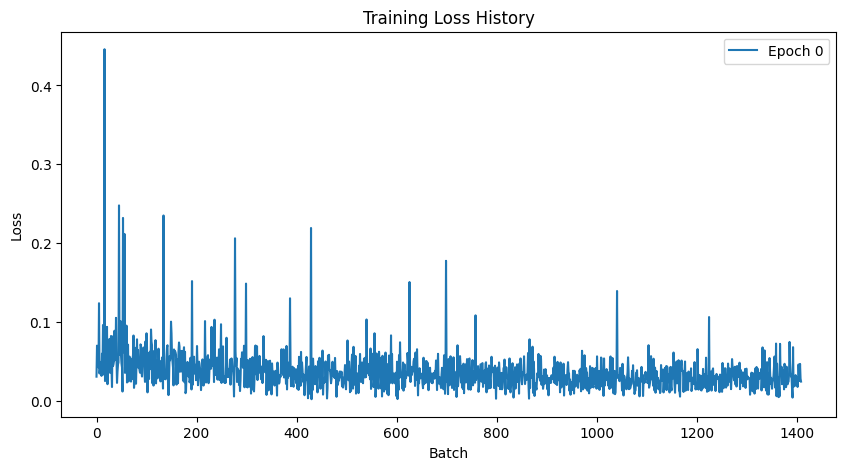

In [97]:
# Load loss history from the JSON file
with open(LOSS_FILENAME, 'r') as f:
    all_losses = json.load(f)

# Plot the loss history
plt.figure(figsize=(10, 5))
for epoch, epoch_losses in enumerate(all_losses):
    plt.plot(epoch_losses, label=f'Epoch {epoch}')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

In [136]:
for i, epoch_loss in enumerate(all_losses):
    print(f"Max Loss Epoch {i}:", max(epoch_loss))
    print(f"Min Loss Epoch {i}:", min(epoch_loss))

[[2.5692760944366455, 0.9790171384811401, 1.3068246841430664, 1.2412109375, 0.9918701648712158, 1.112964391708374, 1.0934878587722778, 1.6470110416412354, 0.7115813493728638, 1.0630087852478027, 1.6758232116699219, 0.9806788563728333, 1.431943416595459, 1.3269057273864746, 0.9796341061592102, 1.372074842453003, 1.333921194076538, 1.1412816047668457, 0.6486691236495972, 0.6136778593063354, 1.001086950302124, 2.823303461074829, 0.8183358311653137, 0.41345131397247314, 0.7211231589317322, 1.1260902881622314, 0.7682401537895203, 0.9219480156898499, 1.388757348060608, 0.779511034488678, 1.2597036361694336, 0.9785486459732056, 0.8202219009399414, 0.6750777959823608, 0.8887925744056702, 0.9946377277374268, 0.8880695700645447, 0.901684045791626, 0.886241614818573, 0.5948796272277832, 0.7855020761489868, 0.7690614461898804, 1.0849474668502808, 0.28720998764038086, 0.8404237031936646, 0.7346302270889282, 0.8562619090080261, 0.9344925284385681, 0.7075697183609009, 0.6502460241317749, 0.6266969442

Number of Iteration: 1410


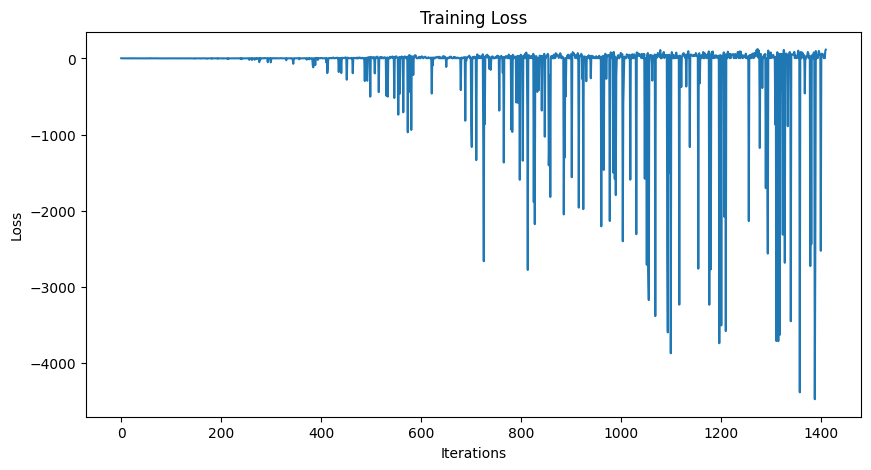

In [125]:
print("Number of Iteration:", len(epoch_losses))

plt.figure(figsize=(10, 5))
for epoch_loss in all_losses:
    plt.plot(epoch_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [98]:
MODEL_FILE = "model_checkpoint_2.pth"

In [99]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), MODEL_FILE)

## Check performance on train set

In [100]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [102]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
model.load_state_dict(torch.load(MODEL_FILE))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

RANDOM IDX: 1099


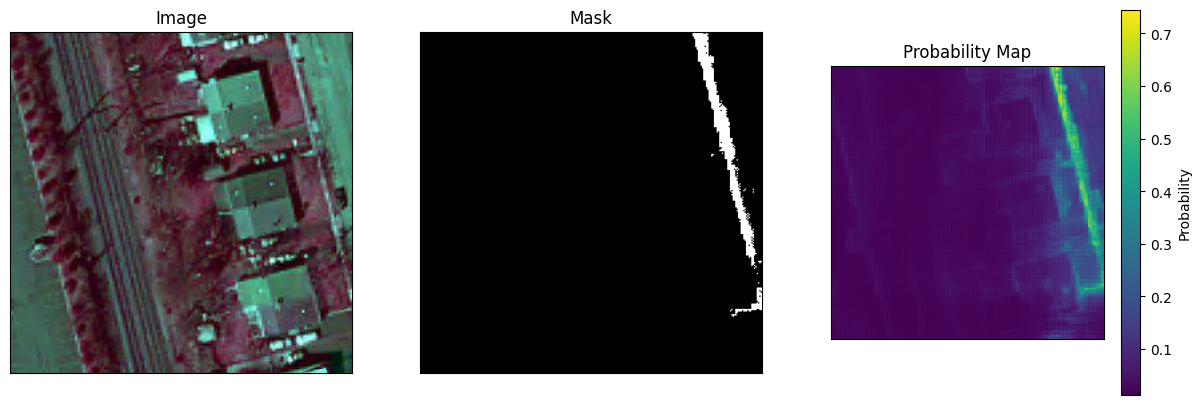

In [110]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, data['imgarr'].shape[0]-1)
print("RANDOM IDX:", idx)
idx = 676
# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
PROBABILITY_THRES = 0.4
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > PROBABILITY_THRES).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right with probability map and color bar
im = axes[2].imshow(medsam_seg_prob, cmap='viridis')  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")
cbar = fig.colorbar(im, ax=axes[2])

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Val

In [114]:
from datasets import load_dataset
val = load_dataset("back2classroom/sidewalks", split='val', streaming=True)
print(next(iter(val)))
print(val)

{'filename': '1016_10_1', 'tfw': b'1.0000000000\r\n0.0000000000\r\n0.0000000000\r\n1.0000000000\r\n0.0000000000\r\n2304.0000000000\r\n', 'tif': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\

In [116]:
val_image_arr = []
val_label_arr = []
val_tif_obj = []
val_lbl_obj = []
fname = []

def byte_string_to_binary(label, normalize=False):
    """
    Convert a byte string to a binary black and white numpy array.

    Args:
    - label: A byte string representing an image.
    - normalize: Boolean indicating whether to normalize the image array (default is False).

    Returns:
    - image_object: PIL Image object.
    - binary_img_arr: A binary black and white numpy array.
    """
    # Convert byte string to PIL Image object
    image_object = io.BytesIO(label)
    image_array = np.array(Image.open(image_object))

    # Thresholding to convert to binary black and white
    if normalize:
        binary_img_arr = (image_array).astype(np.uint8) / 255.0
    else:
        binary_img_arr = (image_array).astype(np.uint8)

    return image_object, binary_img_arr

TOTAL_ITER = 1000
progress_bar = tqdm(total=TOTAL_ITER, desc='Processing')

for idx, item in enumerate(train):
    image_object, image_array = byte_string_to_binary(item['tif'], normalize=False)
    label_object, label_array = byte_string_to_binary(item['label_tif'])
    # Check if the mask is not full black to filter out no-sidewalks img
    if not np.all(label_array[0] == 0):
        fname.append(item['filename'])
        val_tif_obj.append(image_object)
        val_lbl_obj.append(label_object)
        val_image_arr.append(image_array)
        val_label_arr.append(label_array)
    
    # Update the progress bar
    progress_bar.update(1)

    if idx == TOTAL_ITER:
        break

Processing: 1001it [01:02, 15.93it/s] 


In [128]:
# Create a DataFrame
val_df = pd.DataFrame({
    'image': val_tif_obj,
    'label': val_lbl_obj,
    'imgarr': val_image_arr,
    'lblarr': val_label_arr
})

# Export the DataFrame to a CSV file
val_df.to_pickle('dataset_val.pkl')

# Print the dimensions of the DataFrame
print("DataFrame Dimensions:", val_df.shape)

DataFrame Dimensions: (197, 4)


In [131]:
valpkl = pd.read_pickle('dataset_val.pkl')
print(valpkl.head())

                                        image  \
0  <_io.BytesIO object at 0x00000183FF8912B0>   
1  <_io.BytesIO object at 0x00000183FF891080>   
2  <_io.BytesIO object at 0x00000183FF891120>   
3  <_io.BytesIO object at 0x00000183FF8909F0>   
4  <_io.BytesIO object at 0x00000183FF891170>   

                                        label  \
0  <_io.BytesIO object at 0x00000183FFC67150>   
1  <_io.BytesIO object at 0x00000183FFC671A0>   
2  <_io.BytesIO object at 0x00000183FFC671F0>   
3  <_io.BytesIO object at 0x00000183FFC67240>   
4  <_io.BytesIO object at 0x00000183FFC67290>   

                                              imgarr  \
0  [[[122, 132, 134], [193, 219, 218], [181, 243,...   
1  [[[126, 64, 77], [124, 64, 72], [124, 68, 69],...   
2  [[[52, 36, 39], [59, 50, 51], [62, 68, 66], [5...   
3  [[[50, 102, 80], [104, 151, 131], [97, 131, 11...   
4  [[[108, 76, 89], [110, 78, 91], [112, 80, 93],...   

                                              lblarr  
0  [[1, 1, 1, 1, 1

In [132]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_val_dict = {
    "image": [Image.fromarray(img) for img in valpkl['imgarr']],
    "label": [Image.fromarray(mask) for mask in valpkl['lblarr']],
}

# Create the dataset using the datasets.Dataset class
dataset_val = Dataset.from_dict(dataset_val_dict)
dataset_val

Dataset({
    features: ['image', 'label'],
    num_rows: 197
})

In [148]:
idx = random.randint(0, len(dataset_val))
new_image = np.array(dataset_val[idx]["image"])
new_label = np.array(dataset_val[idx]["label"])
print(new)

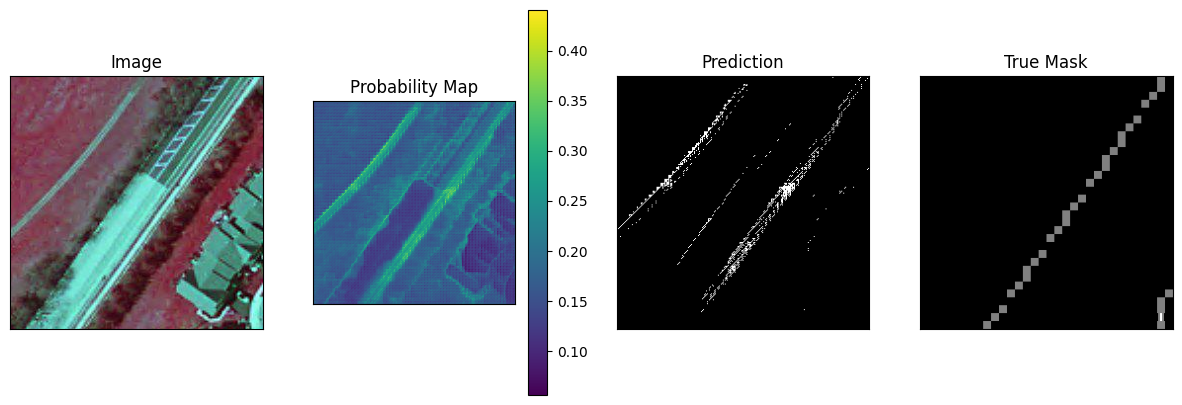

In [161]:
idx = random.randint(0, len(dataset_val))
new_image = np.array(dataset_val[idx]["image"])
new_label = np.array(dataset_val[idx]["label"])

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(new_image, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
model.eval()


# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
PROBABILITY_THRES = 0.3
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > PROBABILITY_THRES).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(new_image, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image
im = axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")
cbar = fig.colorbar(im, ax=axes[1])

# Plot the third image
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Plot the fourth image
axes[3].imshow(new_label, cmap='gray')
axes[3].set_title("True Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()